# Import packages

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import random
import cv2
import sys
import seaborn as sns

# Reading the Images

In [2]:
tumor = []
healthy = []

for i in glob.iglob("Brain_Tumor_Detection/brain_tumor_dataset/yes/*.jpg"):
    image = cv2.imread(i)
    image = cv2.resize(image, (128, 128))
    b, g, r = cv2.split(image)
    image = cv2.merge([r,g,b])
    tumor.append(image)

for i in glob.iglob("Brain_Tumor_Detection/brain_tumor_dataset/no/*.jpg"):
    image = cv2.imread(i)
    image = cv2.resize(image, (128, 128)) 
    b, g, r = cv2.split(image)
    image = cv2.merge([r,g,b])
    healthy.append(image)

In [3]:
healthy = np.array(healthy)
tumor = np.array(tumor)
All = np.concatenate((healthy, tumor))

In [4]:
healthy.shape

(85, 128, 128, 3)

In [5]:
tumor.shape

(86, 128, 128, 3)

In [6]:
np.random.choice(10, 5, replace=False)

array([5, 8, 4, 2, 9])

# Visualizing Brain MRI Images

In [7]:
def plot_random(healthy, tumor, num = 5):
    healthy_image = healthy[np.random.choice(healthy.shape[0], num, replace = False)]
    tumor_image = tumor[np.random.choice(tumor.shape[0], num, replace = False)]
    
    plt.figure(figsize = (10, 5))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('healthy')
        plt.imshow(healthy_image[i])
        
    plt.figure(figsize = (10, 5))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('tumor')
        plt.imshow(tumor_image[i])

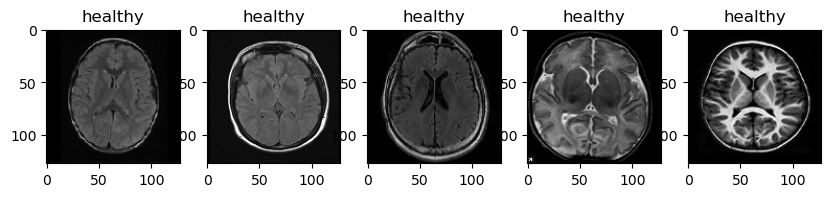

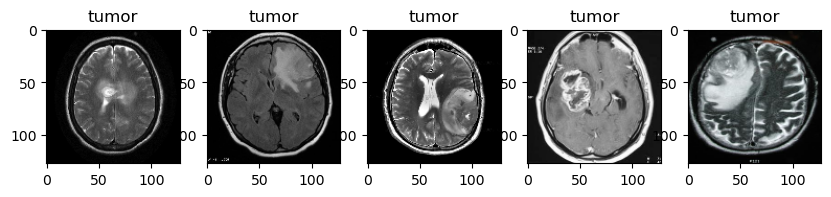

In [8]:
plot_random(healthy, tumor, num=5)

# Create Torch Dataset Class

# What is Pytorch's Abstract Dataset Class

In [9]:
class Dataset(object):
    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

# Creating MRI custom dataset class

In [10]:
class MRI(Dataset):
    def __init__(self):
        
        tumor = []
        healthy = []
        
        for i in glob.iglob("Brain_Tumor_Detection/brain_tumor_dataset/yes/*.jpg"):
            image = cv2.imread(i)
            image = cv2.resize(image,(128, 128)) 
            b, g, r = cv2.split(image)
            image = cv2.merge([r,g,b])
            image = image.reshape((image.shape[2], image.shape[0], image.shape[1])) 
            tumor.append(image)

        for i in glob.iglob("Brain_Tumor_Detection/brain_tumor_dataset/no/*.jpg"):
            image = cv2.imread(i)
            image = cv2.resize(image,(128, 128)) 
            b, g, r = cv2.split(image)
            image = cv2.merge([r,g,b])
            image = image.reshape((image.shape[2], image.shape[0], image.shape[1]))
            healthy.append(image)

        tumor = np.array(tumor, dtype = np.float32)
        healthy = np.array(healthy, dtype = np.float32)
        
        tumor_label = np.ones(tumor.shape[0], dtype = np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype = np.float32)
        
        self.images = np.concatenate((tumor, healthy), axis = 0)
        self.labels = np.concatenate((tumor_label, healthy_label))
        
    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, index):
        sample = {'image': self.images[index], 'label' : self.labels[index]}
        return sample
    
    def normalize(self):
        self.images = self.images/255.0

In [11]:
mri_dataset = MRI()
mri_dataset.normalize()

# Creating a dataloader

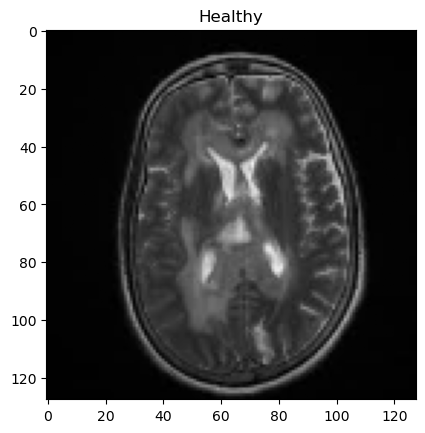

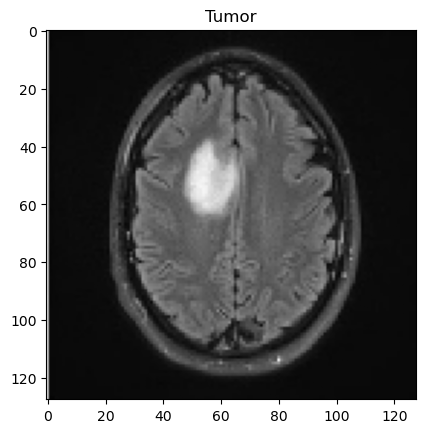

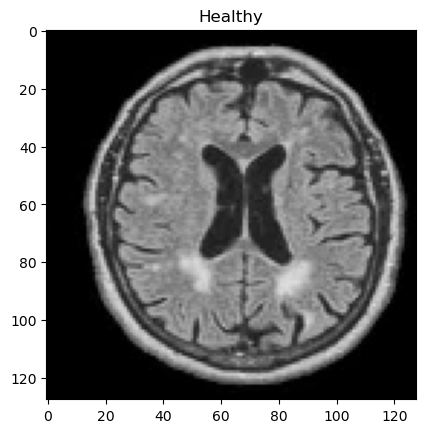

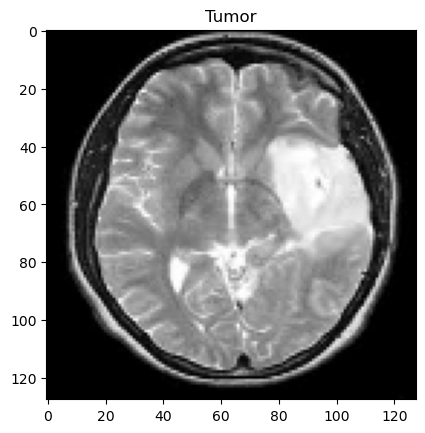

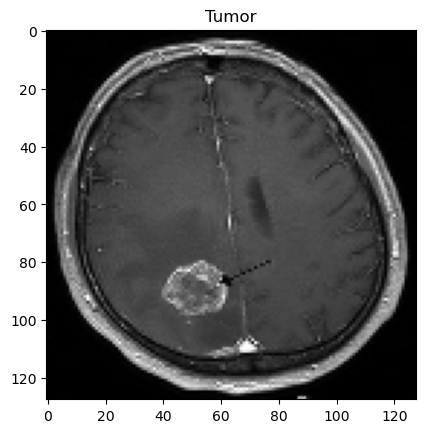

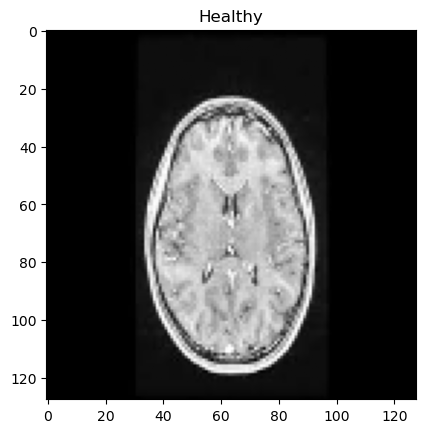

In [12]:
names={0:'Healthy', 1:'Tumor'}
dataloader = DataLoader(mri_dataset, shuffle = True)

for i, sample in enumerate(dataloader):
    image = sample['image'].squeeze()
    image = image.reshape((image.shape[1], image.shape[2], image.shape[0]))
    plt.title(names[sample['label'].item()])
    plt.imshow(image)
    plt.show()
    if i == 5:
        break

# Create a model

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn_model = nn.Sequential(nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5),
        nn.Tanh(), nn.AvgPool2d(kernel_size = 2, stride = 5), nn.Conv2d(in_channels = 6, out_channels = 16, 
        kernel_size = 5), nn.Tanh(), nn.AvgPool2d(kernel_size = 2, stride = 5))
    
        self.fc_model = nn.Sequential(nn.Linear(in_features = 256, out_features = 120), nn.Tanh(), 
        nn.Linear(in_features = 120, out_features = 84), nn.Tanh(), nn.Linear(in_features = 84, out_features = 1))
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = F.sigmoid(x)
        
        return x

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cpu_tensor = torch.rand(10).to(device)
gpu_tensor = cpu_tensor.to(device)

print(cpu_tensor, cpu_tensor.dtype, type(cpu_tensor), cpu_tensor.type())
print(gpu_tensor, gpu_tensor.dtype, type(gpu_tensor), gpu_tensor.type())
print(cpu_tensor * gpu_tensor)

tensor([0.1421, 0.2997, 0.8574, 0.7010, 0.4913, 0.8169, 0.9822, 0.0272, 0.9665,
        0.3200]) torch.float32 <class 'torch.Tensor'> torch.FloatTensor
tensor([0.1421, 0.2997, 0.8574, 0.7010, 0.4913, 0.8169, 0.9822, 0.0272, 0.9665,
        0.3200]) torch.float32 <class 'torch.Tensor'> torch.FloatTensor
tensor([2.0180e-02, 8.9795e-02, 7.3507e-01, 4.9140e-01, 2.4140e-01, 6.6731e-01,
        9.6469e-01, 7.3757e-04, 9.3409e-01, 1.0237e-01])


/home/common/anaconda3/lib/python3.9/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


# Evaluate a New-Born Neural Network!

In [15]:
mri_dataset = MRI()
mri_dataset.normalize()
device = torch.device('cpu:0')
# print(torch.device.cuda)

model = CNN().to(device)
# print(model)

In [16]:
dataloader = DataLoader(mri_dataset, batch_size = 32, shuffle = False)

In [17]:
model.eval()
outputs = []
y_true = []

with torch.no_grad():
    for D in dataloader:
        image = D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(image)

        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())

/home/common/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [18]:
print(model)

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)


In [19]:
outputs = np.concatenate(outputs, axis = 0).squeeze()
y_true = np.concatenate(y_true, axis = 0).squeeze()

In [20]:
def threshold(scores,threshold = 0.50, min = 0, max = 1.0):
    x = np.array(list(scores))
    x[x >= threshold] = max
    x[x < threshold] = min
    return x

In [21]:
accuracy_score(y_true, threshold(outputs))

0.5087719298245614

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

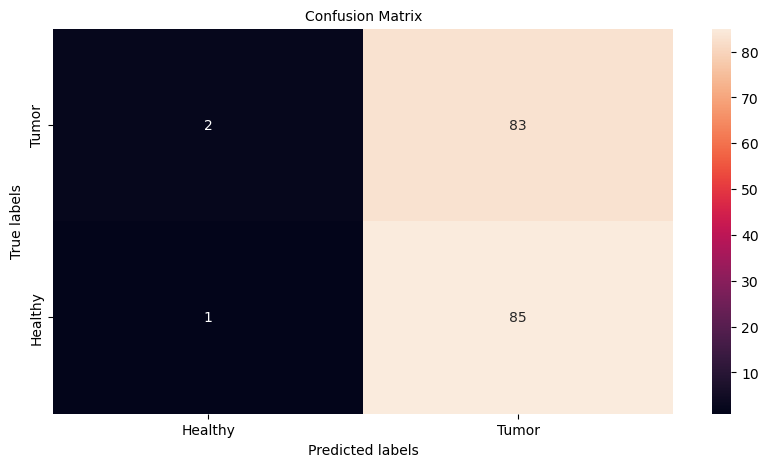

In [22]:
plt.figure(figsize=(10, 5))
cm = confusion_matrix(y_true, threshold(outputs))
ax= plt.subplot()
sns.heatmap(cm, annot = True, fmt = 'g', ax = ax, annot_kws = {'size': 10})

ax.set_xlabel('Predicted labels', fontsize=10)
ax.set_ylabel('True labels', fontsize=10) 
ax.set_title('Confusion Matrix', fontsize=10)
ax.xaxis.set_ticklabels(['Healthy','Tumor'], fontsize=10)
ax.yaxis.set_ticklabels(['Tumor','Healthy'], fontsize=10)

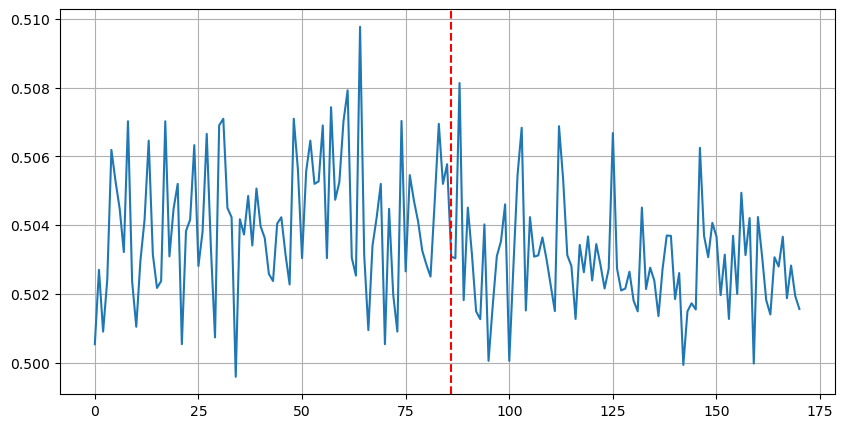

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

# Train the dumb model

In [24]:
eta = 0.0001
EPOCH = 400

optimizer = torch.optim.Adam(model.parameters(), lr=eta)
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
model.train()

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [25]:
for epoch in range(1, EPOCH):
    losses = []
    for D in dataloader:
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(data)
      
        error = nn.BCELoss() 
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
    if(epoch + 1)%10 == 0:
        print('Train Epoch: {}\tLoss: {:.6f}' .format(epoch+1, np.mean(losses)))

/home/common/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 10	Loss: 0.678261
Train Epoch: 20	Loss: 0.629963
Train Epoch: 30	Loss: 0.557541
Train Epoch: 40	Loss: 0.544576
Train Epoch: 50	Loss: 0.526285
Train Epoch: 60	Loss: 0.478734
Train Epoch: 70	Loss: 0.457453
Train Epoch: 80	Loss: 0.420596
Train Epoch: 90	Loss: 0.401006
Train Epoch: 100	Loss: 0.402337
Train Epoch: 110	Loss: 0.373584
Train Epoch: 120	Loss: 0.329444
Train Epoch: 130	Loss: 0.311585
Train Epoch: 140	Loss: 0.320568
Train Epoch: 150	Loss: 0.266435
Train Epoch: 160	Loss: 0.240751
Train Epoch: 170	Loss: 0.227104
Train Epoch: 180	Loss: 0.203874
Train Epoch: 190	Loss: 0.182373
Train Epoch: 200	Loss: 0.162257
Train Epoch: 210	Loss: 0.139089
Train Epoch: 220	Loss: 0.133645
Train Epoch: 230	Loss: 0.104309
Train Epoch: 240	Loss: 0.097672
Train Epoch: 250	Loss: 0.085245
Train Epoch: 260	Loss: 0.060675
Train Epoch: 270	Loss: 0.048299
Train Epoch: 280	Loss: 0.038154
Train Epoch: 290	Loss: 0.032477
Train Epoch: 300	Loss: 0.027870
Train Epoch: 310	Loss: 0.020791
Train Epoch: 320	

# Evaluate a smart model

In [26]:
model.eval()
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)
outputs = []
y_true = []

with torch.no_grad():
    for D in dataloader:
        image =  D['image'].to(device)
        label = D['label'].to(device)
        
        y_hat = model(image)
        
        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())
        
outputs = np.concatenate( outputs, axis=0)
y_true = np.concatenate( y_true, axis=0)

In [27]:
accuracy_score(y_true, threshold(outputs))

1.0

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

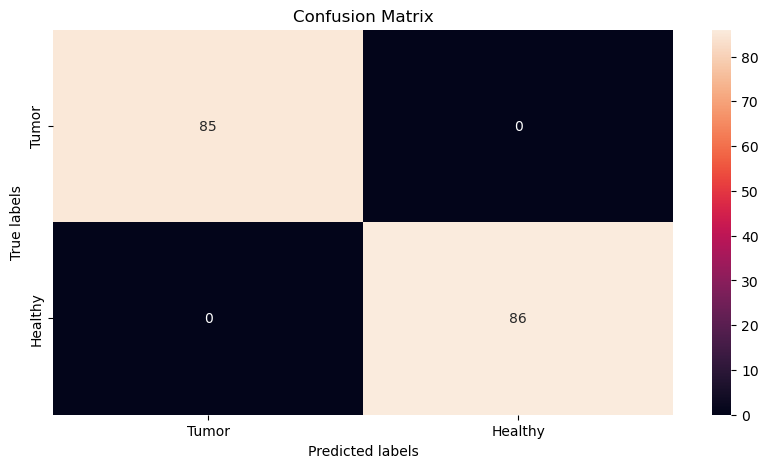

In [28]:
cm = confusion_matrix(y_true, threshold(outputs))
plt.figure(figsize=(10,5))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Tumor','Healthy'])
ax.yaxis.set_ticklabels(['Tumor','Healthy'])

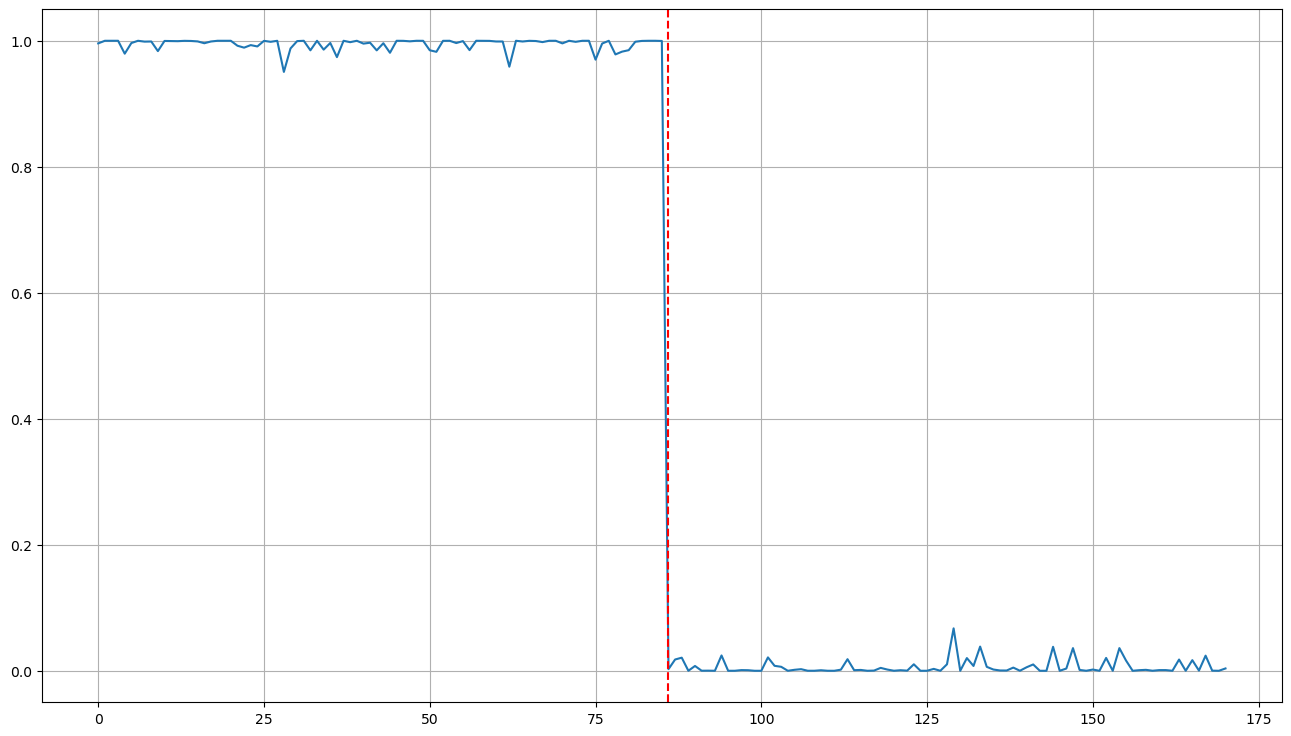

In [29]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

# Visualising the Feature Maps of the Convolutional Filters

In [30]:
model

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [31]:
no_of_layers = 0
conv_layers = []

In [32]:
model_children = list(model.children())
model_children

[Sequential(
   (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
   (1): Tanh()
   (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
   (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
   (4): Tanh()
   (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
 ),
 Sequential(
   (0): Linear(in_features=256, out_features=120, bias=True)
   (1): Tanh()
   (2): Linear(in_features=120, out_features=84, bias=True)
   (3): Tanh()
   (4): Linear(in_features=84, out_features=1, bias=True)
 )]

In [33]:
for child in model_children:
    if type(child) == nn.Sequential:
        for layer in child.children():
            if type(layer) == nn.Conv2d:
                no_of_layers += 1
                conv_layers.append(layer)

In [34]:
conv_layers

[Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1)),
 Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))]

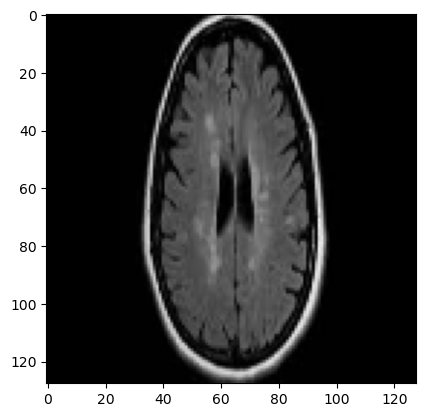

In [35]:
img = mri_dataset[100]['image']
plt.imshow(img.reshape(128,128,3))

In [36]:
img = torch.from_numpy(img).to(device)

In [37]:
img.shape

torch.Size([3, 128, 128])

In [38]:
img = img.unsqueeze(0)
img.shape

torch.Size([1, 3, 128, 128])

In [39]:
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results

Layer :  1


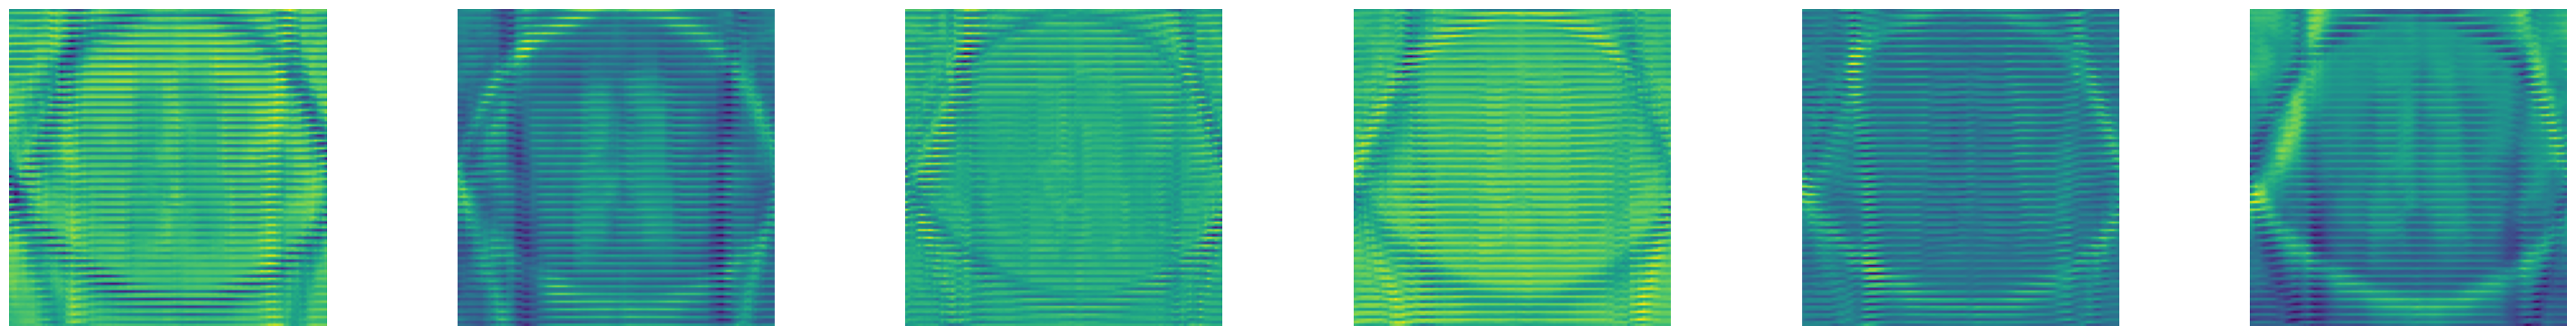

Layer :  2


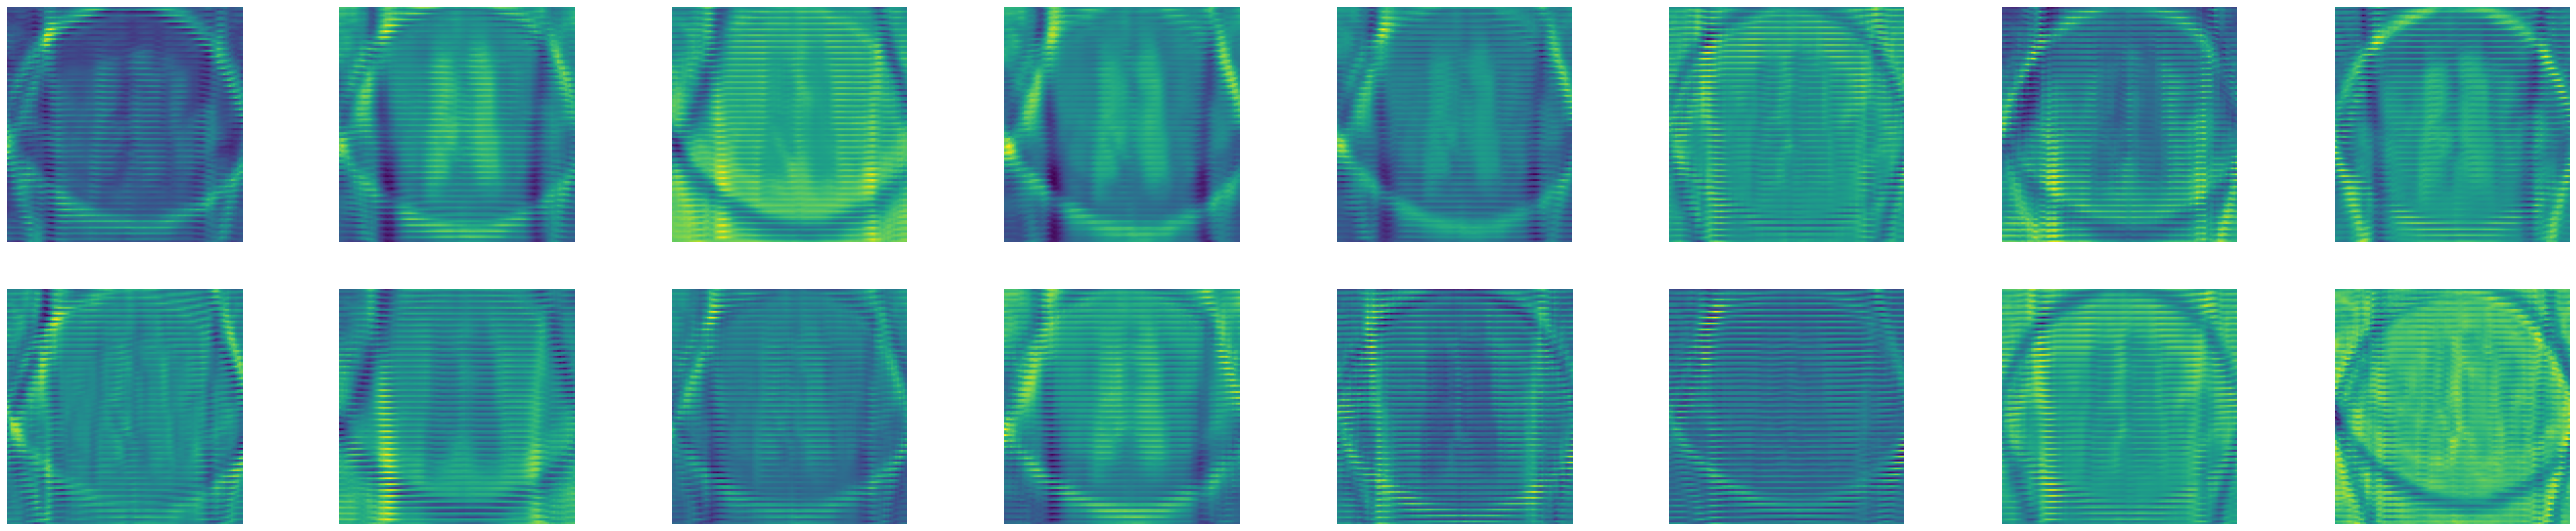

In [40]:
for num_layer in range(len(outputs)):
    plt.figure(figsize = (50, 10))
    layer_viz = outputs[num_layer].squeeze()
    print('Layer : ', num_layer+1)
    for i, f in enumerate(layer_viz):
        plt.subplot(2, 8, i + 1)
        plt.imshow(f.detach().cpu().numpy())
        plt.axis('off')
    plt.show()
    plt.close()

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
class MRI(Dataset):
    def __init__(self):
        # Variables to hold the Training data and Validation data
        self.X_train, self.y_train, self.X_val, self.y_val = None, None, None, None
        self.mode = 'train'
        
        tumor = []
        healthy = []
        
        for f in glob.iglob('Brain_Tumor_Detection/brain_tumor_dataset/yes/*.jpg'):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) 
            tumor.append(img)

        for f in glob.iglob('Brain_Tumor_Detection/brain_tumor_dataset/no/*.jpg'):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        tumor = np.array(tumor,dtype = np.float32)
        healthy = np.array(healthy,dtype = np.float32)
        
        tumor_label = np.ones(tumor.shape[0], dtype = np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype = np.float32)
        
        self.images = np.concatenate((tumor, healthy), axis = 0)
        self.labels = np.concatenate((tumor_label, healthy_label))
    
    def train_val_split(self):
        self.X_train, self.X_val, self.y_train, self.y_val = \
        train_test_split(self.images, self.labels, test_size = 0.20, random_state = 42)
        
    def __len__(self):
        if self.mode == 'train':
            return self.X_train.shape[0]
        elif self.mode == 'val':
            return self.X_val.shape[0]
    
    def __getitem__(self, idx):
        if self.mode== 'train':
            sample = {'image': self.X_train[idx], 'label': self.y_train[idx]}
        
        elif self.mode== 'val':
            sample = {'image': self.X_val[idx], 'label': self.y_val[idx]}
        
        return sample
    
    def normalize(self):
        self.images = self.images/255.0

In [43]:
mri_dataset = MRI()
mri_dataset.normalize()
mri_dataset.train_val_split()

In [44]:
train_dataloader = DataLoader(mri_dataset, batch_size = 32, shuffle = True)
val_dataloader = DataLoader(mri_dataset, batch_size = 32, shuffle = False)

In [45]:
device = torch.device('cpu:0')
model = CNN().to(device)

In [46]:
eta = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr = eta)

In [47]:
epoch_train_loss = []
epoch_val_loss = []

In [48]:
for epoch in range(1, 600):
    train_losses = []
    
    # train for the current epoch
    model.train()
    mri_dataset.mode = 'train'
    for D in train_dataloader:
        # Train the model
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        
        y_hat = model(data)
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    epoch_train_loss.append(np.mean(train_losses))
    
    # validate for the current epoch
    val_losses = []
    model.eval()
    mri_dataset.mode = 'val'
    
    for D in val_dataloader:            
        data = D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(data)
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        val_losses.append(loss.item())
    
    epoch_val_loss.append(np.mean(val_losses))
    
    if (epoch+1)%10 == 0:
        print('Train Epoch: {}\tTrain Loss: {:.6f}\tVal Loss: {:.6f}' .format(epoch+1, np.mean(train_losses), np.mean(val_losses)))

/home/common/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 10	Train Loss: 0.681671	Val Loss: 0.690418
Train Epoch: 20	Train Loss: 0.654709	Val Loss: 0.672667
Train Epoch: 30	Train Loss: 0.611634	Val Loss: 0.626671
Train Epoch: 40	Train Loss: 0.585256	Val Loss: 0.554313
Train Epoch: 50	Train Loss: 0.560504	Val Loss: 0.510342
Train Epoch: 60	Train Loss: 0.534993	Val Loss: 0.490404
Train Epoch: 70	Train Loss: 0.498848	Val Loss: 0.463779
Train Epoch: 80	Train Loss: 0.480710	Val Loss: 0.449531
Train Epoch: 90	Train Loss: 0.441889	Val Loss: 0.453835
Train Epoch: 100	Train Loss: 0.418896	Val Loss: 0.450276
Train Epoch: 110	Train Loss: 0.350463	Val Loss: 0.453819
Train Epoch: 120	Train Loss: 0.329250	Val Loss: 0.458581
Train Epoch: 130	Train Loss: 0.338218	Val Loss: 0.479887
Train Epoch: 140	Train Loss: 0.363120	Val Loss: 0.503958
Train Epoch: 150	Train Loss: 0.296623	Val Loss: 0.517484
Train Epoch: 160	Train Loss: 0.302505	Val Loss: 0.554068
Train Epoch: 170	Train Loss: 0.233435	Val Loss: 0.604928
Train Epoch: 180	Train Loss: 0.222688	Va

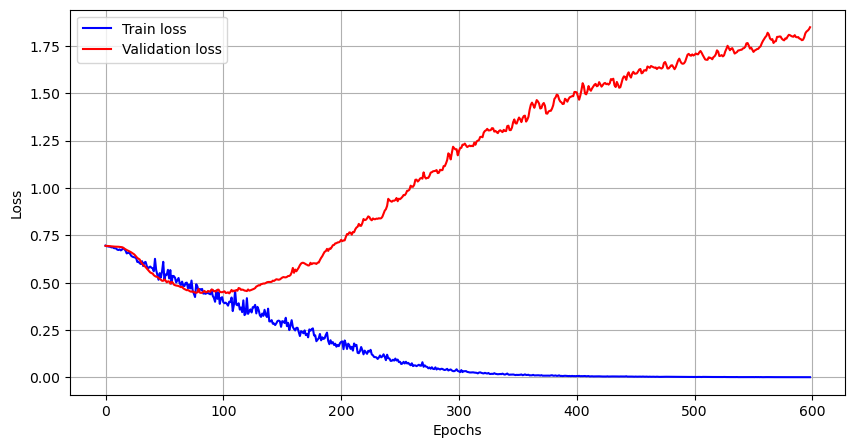

In [49]:
plt.figure(figsize = (10, 5))
plt.plot(epoch_train_loss, c = 'b', label = 'Train loss')
plt.plot(epoch_val_loss, c = 'r', label = 'Validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Loss', fontsize = 10)
plt.show()